In [ ]:
#Расчёт пластинчатого ТО (волны-sandia)
# рекуператор
import matplotlib.pyplot as pt
import numpy as n
#import json, CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI as p
#CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, 'C:\\Program Files (x86)\\REFPROP\\')
from scipy.optimize import root
import math as m
#исходные данные:

T11 = 663.576843
T12 = 70
T21 = 60.2275183


#T22 = 640.595
#Q = 452413

G1 = 636.395571
G2 = 543.18

P11=3000000
P21=30000000
P12 = P11
P22 = P21

##############################################
CO2  = 'REFPROP::CO2'
H2O  = 'REFPROP::WATER'
O2   = 'REFPROP::Oxygen'
MIX1 =  'REFPROP::CO2[0.931]&WATER[0.069]'
MIX2 =  'REFPROP::CO2[0.993]&WATER[0.007]'
MIX05 =  'REFPROP::CO2[0.95]&WATER[0.05]' #Для транспортный свойств


H11  = p('H','T', T11+273.15, 'P', P11, MIX1)
H12  = p('H','T', T12+273.15, 'P', P11, MIX1)
H21  = p('H','T', T21+273.15, 'P', P21, MIX2)

#Разбиение по энтальпии:
s    = 500 #Кол-во шагов
step = (H11-H12)/(s) 

#Нулевые массивы:
t1   = n.zeros(s+1)
t2   = n.zeros(s+1)
Q    = n.zeros(s+1)

#Противоток:
h11 = H11
i=0
for i in range(s+1):
    t1[i] = p('T','H', h11, 'P', P11, MIX1)-273.15 
    h12 = h11 - step
    dQ = G1 * (h11-h12)
    if i < s:
        Q[i+1]=Q[i]+dQ
    h11 = h12
h21 = H21
i=0
for i in range(s+1):
    t2[s-i] = p('T','H', h21, 'P', P21, MIX2)-273.15  
    h22 = h21+((Q[s-i]-Q[s-i-1])/G2)
    h21 = h22
DT=t1-t2
##############################################


t1av = n.zeros(s)
t2av = n.zeros(s)
ro1 = n.zeros(s)
ro2 = n.zeros(s)
nu1 = n.zeros(s)
nu2 = n.zeros(s)
lambda1 = n.zeros(s)
lambda2 = n.zeros(s)
Pr1 = n.zeros(s)
Pr2 = n.zeros(s)
DTav = n.zeros(s)
w1 = n.zeros(s)
w2= n.zeros(s)
Re1= n.zeros(s)
Re2= n.zeros(s)
Nu1= n.zeros(s)
Nu2= n.zeros(s)
f1= n.zeros(s)
f2= n.zeros(s)
alpha1= n.zeros(s)
alpha2= n.zeros(s)
K= n.zeros(s)
F= n.zeros(s+1)
L= n.zeros(s+1)
P1= n.zeros(s+1)
P2= n.zeros(s+1)
#Для каждого участка:
for i in range(s):
    #Свойства
    t1av[i]   =(t1[i]+t1[i+1])/2
    t2av[i]   =(t2[i]+t2[i+1])/2
    ro1[i]    =p('D','T', t1av[i]+273.15, 'P', P11, MIX1)
    ro2[i]    =p('D','T', t2av[i]+273.15, 'P', P21, MIX2)
    nu1[i]    =p('V','T', t1av[i]+273.15, 'P', P11, MIX05)
    nu2[i]    =p('V','T', t2av[i]+273.15, 'P', P21, MIX05)
    lambda1[i]=p('L','T', t1av[i]+273.15, 'P', P11, MIX05)
    lambda2[i]=p('L','T', t2av[i]+273.15, 'P', P21, MIX05)
    Pr1[i]    =p('PRANDTL','T', t1av[i]+273.15, 'P', P11, MIX05)
    Pr2[i]    =p('PRANDTL','T', t2av[i]+273.15, 'P', P21, MIX05)
    DTav[i]   =t1av[i]-t2av[i]
#От выпадающих Pr:
for i in range(1,s):
    if abs(Pr1[i]-Pr1[i-1])>Pr1[i-1]:
        Pr1[i]=p('PRANDTL','T', t1[i]+273.15, 'P', P11, CO2)
    if abs(Pr2[i]-Pr2[i-1])>Pr2[i-1]:
        Pr2[i]=p('PRANDTL','T', t2[i]+273.15, 'P', P21, CO2)

#Геометрия
delta = 0.002       #толщина металла
hc = 0.00094        #высота канала
wpl = 1             #ширина пластины
wc = wpl/1.254      #ширина проходного сечения
fprohc = wc*hc      #проходное сечение 1 пластины
dh =0.00109         #характерный размер
hpl = hc+delta      #высота пластины
lambdaw = 20        #теплопроводность металла

#Геометрия "выхода":
roout1 = p('D','T', t1[s]+273.15, 'P', P11, MIX1)
roout2 = p('D','T', t2[s]+273.15, 'P', P21, MIX2)




wout1=3
Fproh1 = G1/(roout1*wout1)
Npl1 = m.ceil(Fproh1/fprohc)
Npl2 = Npl1/2
Nsumm = Npl1+Npl2
Fproh2 = Npl2*fprohc
Fl = ((Npl1+Npl2)/2)*(1.905)


P1[0]=P11
P2[0]=P21
#Для каждого участка:
for i in range(s):
    w1[i] = G1/(ro1[i]*Fproh1)
    w2[i] = G2/(ro2[i]*Fproh2)
    Re1[i]=w1[i]*dh/nu1[i]
    Re2[i]=w2[i]*dh/nu2[i]
    Nu1[i] = 0.1740*Re1[i]**0.593*Pr1[i]**0.430
    Nu2[i] = 0.1740*Re2[i]**0.593*Pr2[i]**0.430
    f1[i] = 0.4545*Re1[i]**-0.405
    f2[i]= 0.4545*Re2[i]**-0.405
    alpha1[i] = Nu1[i]*lambda1[i]/dh
    alpha2[i] = Nu2[i]*lambda2[i]/dh
    K[i] = 1/((1/alpha1[i])+(delta/lambdaw)+(1/alpha2[i]))
    dF = (Q[i+1]-Q[i])/(K[i]*DTav[i])
    dL = dF/Fl
    if i < s:
        F[i+1]=F[i]+dF
    if i < s:
        L[i+1]=L[i]+dL
    dP1 = f1[i]*dL/dh*ro1[i]*w1[i]**2/2
    dP2 = f2[i]*dL/dh*ro2[i]*w2[i]**2/2
    if i < s:
        P1[i+1]=P1[i]-dP1
        P2[i+1]=P2[i]-dP2
    DP1 = P1[0]-P1[s]
    DP2 = P2[0]-P2[s]
print('++')

Температуры:
663.5990000184298 83.00000180601398
640.5133248765862 60.21540004168577
Тепловая мощность: 455338340.5304248
Длина ТО: 41.43722173904622
Площадь ТО: 341248.57374589326
Минимальный темп. напор: 10.394593217555894


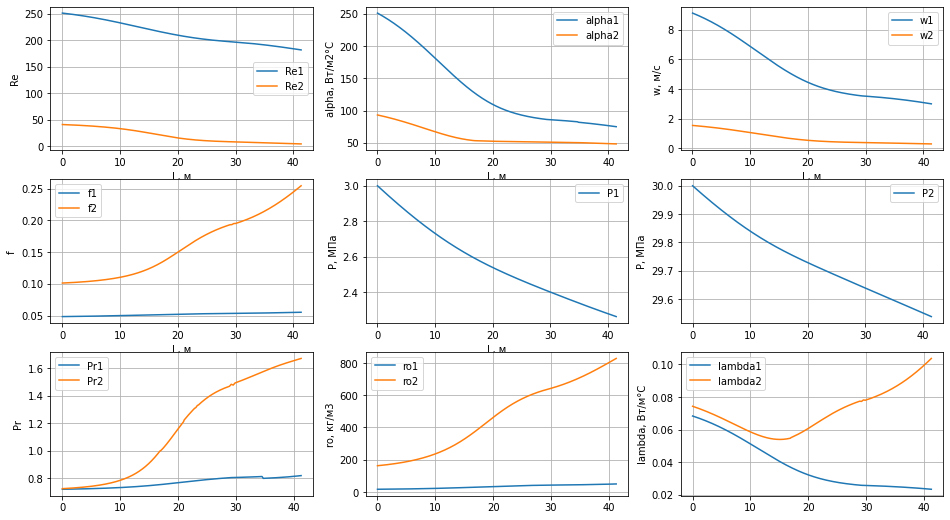

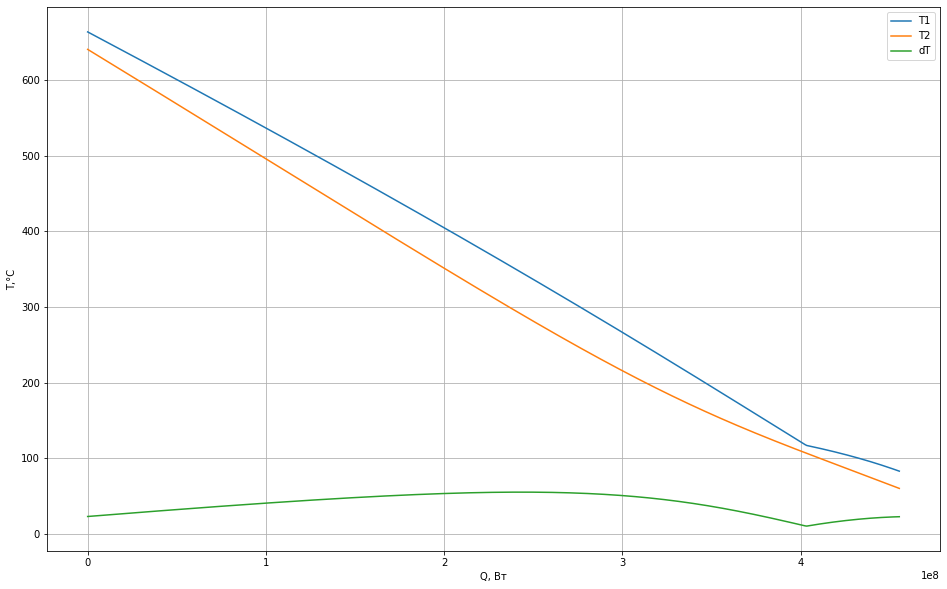

In [12]:
print('Температуры:')
print(t1[0],t1[s])
print(t2[0],t2[s])
print('Тепловая мощность:',Q[s])
print('Длина ТО:',L[s])
print('Площадь ТО:',F[s])
print('Минимальный темп. напор:',min(DT))

pt.figure(figsize=(16, 9))
x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [Re1[i] for i in (range(s))]
y2 = [Re2[i] for i in (range(s))]
pt.subplot(331)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['Re1','Re2'])
pt.xlabel('L, м')
pt.ylabel('Re')

x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [alpha1[i] for i in (range(s))]
y2 = [alpha2[i] for i in (range(s))]
pt.subplot(332)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['alpha1','alpha2'])
pt.xlabel('L, м')
pt.ylabel('alpha, Вт/м2°С')

x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [w1[i] for i in (range(s))]
y2 = [w2[i] for i in (range(s))]
pt.subplot(333)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['w1','w2'])
pt.xlabel('L, м')
pt.ylabel('w, м/с')

x  = [(L[i]+L[i+1])/2 for i in range(s)]  
y1 = [f1[i] for i in (range(s))]
y2 = [f2[i] for i in (range(s))]
pt.subplot(334)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['f1','f2'])
pt.xlabel('L, м')
pt.ylabel('f')

x  = [L[i] for i in range(s+1)]  
y1 = [P1[i]/1000000 for i in (range(s+1))]
pt.subplot(335)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['P1'])
pt.xlabel('L, м')
pt.ylabel('P, МПа')

x  = [L[i] for i in range(s+1)]  
y1 = [P2[i]/1000000 for i in (range(s+1))]
pt.subplot(336)
pt.plot(x, y1)
pt.grid(True)
pt.legend(['P2'])
pt.ylabel('P, МПа')

x  = [L[i] for i in range(s)]  
y1 = [Pr1[i] for i in (range(s))]
y2 = [Pr2[i] for i in (range(s))]
pt.subplot(337)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['Pr1','Pr2'])
pt.ylabel('Pr')

x  = [L[i] for i in range(s)]  
y1 = [ro1[i] for i in (range(s))]
y2 = [ro2[i] for i in (range(s))]
pt.subplot(338)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['ro1','ro2'])
pt.ylabel('ro, кг/м3')

x  = [L[i] for i in range(s)]  
y1 = [lambda1[i] for i in (range(s))]
y2 = [lambda2[i] for i in (range(s))]
pt.subplot(339)
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.legend(['lambda1','lambda2'])
pt.ylabel('lambda, Вт/м°С')
pt.show()


x  = [Q[i] for i in range(s+1)]  
y1 = [t1[i] for i in (range(s+1))]
y2 = [t2[i] for i in (range(s+1))]
y3 = [DT[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x, y2,x,y3)
pt.grid(True)
pt.legend(['T1','T2','dT'])
pt.ylabel('T,°C')
pt.xlabel('Q, Вт')
pt.show()